In [1]:
import numpy as np
import pandas as pd

from os import path
import pickle
import re

import matplotlib.pyplot as plt
import seaborn as sns

import itertools

import time

from scipy.spatial.distance import pdist, cdist, squareform

from sklearn.decomposition import PCA

from sklearn.cluster import KMeans, MiniBatchKMeans, DBSCAN

from sklearn.metrics import silhouette_score, calinski_harabaz_score

### Import Data

In [2]:
fd = ['..','data','interim']

# Train set
fp = path.join(*fd, 'train.p')
with open(file=fp, mode='rb') as file:
    train = pickle.load(file)

### Cross Tabulation

In [3]:
train['aisle'].nunique()

134

In [4]:
train['user_id'].nunique()

206209

In [5]:
tab = {}

In [6]:
# Regular counts & scaled counts
tab['count'] = pd.crosstab(index=train['user_id'], columns=train['aisle'])
tab['count_norm'] = tab['count'].apply(lambda x: (x-x.min())/(x.max()-x.min()), axis=1)
tab['count_log_norm'] = tab['count'].apply(lambda x: np.log(1+x)).apply(lambda x: (x-x.min())/(x.max()-x.min()), axis=1)

In [7]:
# Tallied counts & scaled counts (i.e. max 1 per order)
# Remove duplicate records of department per order
temp = train.drop_duplicates(subset=['order_id', 'aisle'])
tab['tally'] = pd.crosstab(index=temp['user_id'], columns=temp['aisle'])
tab['tally_norm'] = tab['tally'].apply(lambda x: (x-x.min())/(x.max()-x.min()), axis=1)
tab['tally_log_norm'] = tab['tally'].apply(lambda x: np.log(1+x)).apply(lambda x: (x-x.min())/(x.max()-x.min()), axis=1)

In [8]:
# Order aisle proportions
p_temp = train.groupby(['user_id','order_id','aisle'])['product_id'].count().unstack().reset_index(level=1, drop=True)
p_temp = p_temp.div(p_temp.sum(axis=1).values,axis=0)
p_temp = p_temp.fillna(0).groupby('user_id').mean()
p_mean_norm = p_temp.apply(lambda x: (x-x.min())/(x.max()-x.min()), axis=1)

In [9]:
tab['p_mean_norm'] = p_mean_norm

In [10]:
tab['count'].shape

(206209, 134)

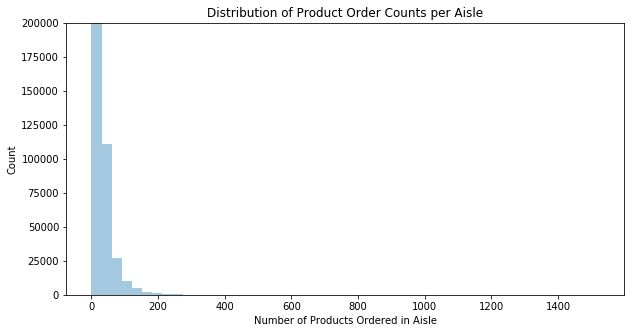

In [21]:
plt.figure(figsize=(10,5))

ax = sns.distplot(tab['count'].unstack(), kde=False)

ax.set_title('Distribution of Product Order Counts per Aisle')
ax.set_ylabel('Count')
ax.set_xlabel('Number of Products Ordered in Aisle')
ax.set_ylim(top=200000)

plt.show()

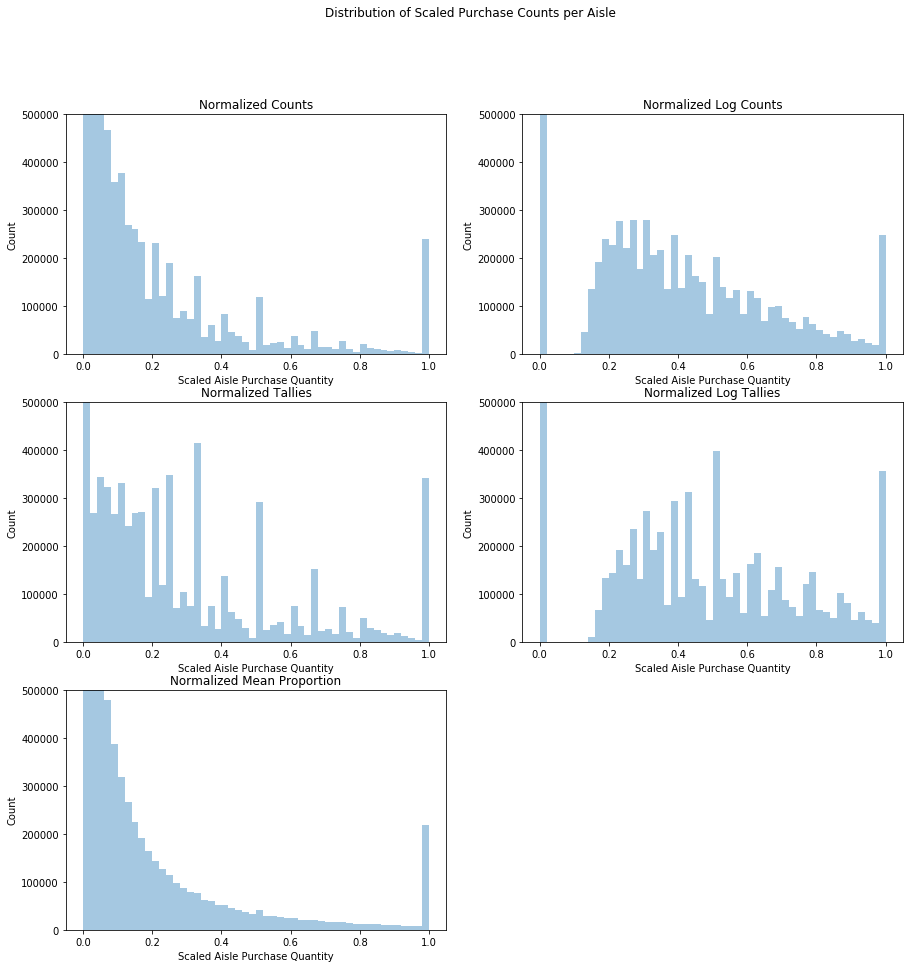

In [15]:
fig, axs = plt.subplots(3,2, figsize=(15,15))

sns.distplot(tab['count_norm'].unstack(), kde=False, ax=axs[0][0])
sns.distplot(tab['count_log_norm'].unstack(), kde=False, ax=axs[0][1])
sns.distplot(tab['tally_norm'].unstack(), kde=False, ax=axs[1][0])
sns.distplot(tab['tally_log_norm'].unstack(), kde=False, ax=axs[1][1])
sns.distplot(tab['p_mean_norm'].unstack(), kde=False, ax=axs[2][0])

for ax in axs.flatten():
    ax.set_xlabel('Scaled Aisle Purchase Quantity')
    ax.set_ylabel('Count')
    ax.set_ylim(top=500000)
    
axs[0][0].set_title('Normalized Counts')
axs[0][1].set_title('Normalized Log Counts')
axs[1][0].set_title('Normalized Tallies')
axs[1][1].set_title('Normalized Log Tallies')
axs[2][0].set_title('Normalized Mean Proportion')
axs[2][1].axis('off')

fig.suptitle('Distribution of Scaled Purchase Counts per Aisle')

plt.show()

### Dimensionality Reduction

In [22]:
def plot_pca_var(X, p=0.9):
    
    # Create & fit PCA object
    pca = PCA()
    pca.fit(X)
    
    # Create figure
    plt.figure(figsize=(10,5))
    
    # Get the explained variance and cumulative sum
    n = len(pca.explained_variance_ratio_)
    exp_var = pca.explained_variance_ratio_
    exp_var_cumsum = np.cumsum(exp_var)
    
    # Plot bars for explained variance of each component
    plt.bar(np.arange(1, n+1, 1), exp_var, align='center', label='Explained Variance Ratio')
    # Plot steps for cumulative explained variance
    plt.step(np.arange(1, n+1, 1), exp_var_cumsum, where='mid', label='Cumulative Explained Variance Ratio')
    
    # n_components at which minimum cumalative variance explained is satisfied
    x = next(i for i, n in enumerate(exp_var_cumsum) if n >= p) + 1
    # Markings at the specified desired percentage variance explained
    plt.hlines(p, 0, n, label='{}% Explained Variance Ratio'.format(p*100), lw=1, color='r', linestyle='dashed')
    plt.plot([x, x], [0, p], linestyle='--',color='k', markeredgewidth=3, ms=8, lw=1)
    plt.plot([x], [p], marker='x', color='k', markeredgewidth=2, ms=8, lw=.5)
    plt.annotate(x, (x+.5, p-0.05))
    
    # Generic plot labels
    plt.xlabel('Principal Components')
    plt.ylabel('Explained Variance Ratio')
    plt.legend(bbox_to_anchor=(1,1))
    plt.xlim(0, n)
    plt.title('Principal Component Analysis')
        
    # return figure
    return plt.gcf()

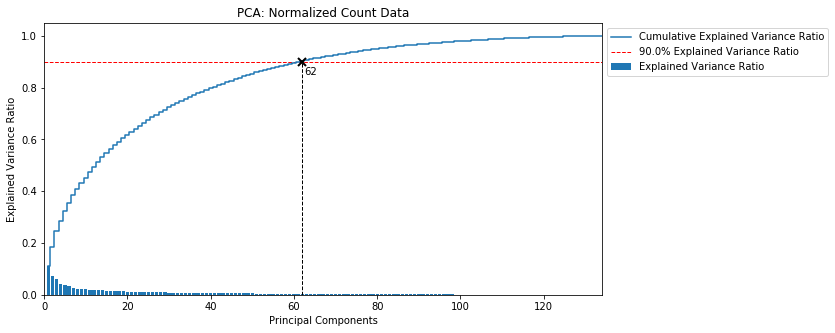

In [23]:
fig = plot_pca_var(tab['count_norm'].values, 0.90)
plt.title('PCA: Normalized Count Data')
plt.show()

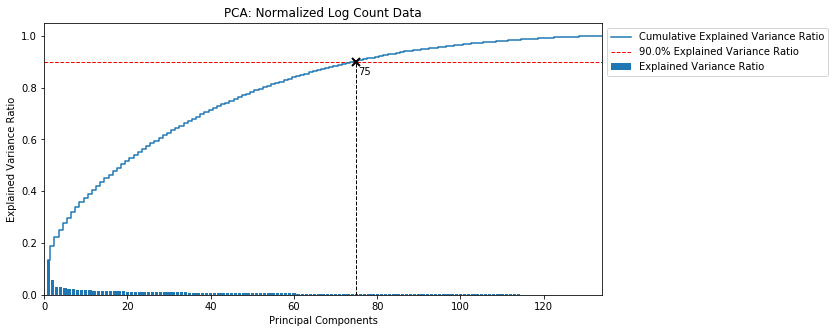

In [24]:
fig = plot_pca_var(tab['count_log_norm'].values, 0.90)
plt.title('PCA: Normalized Log Count Data')
plt.show()

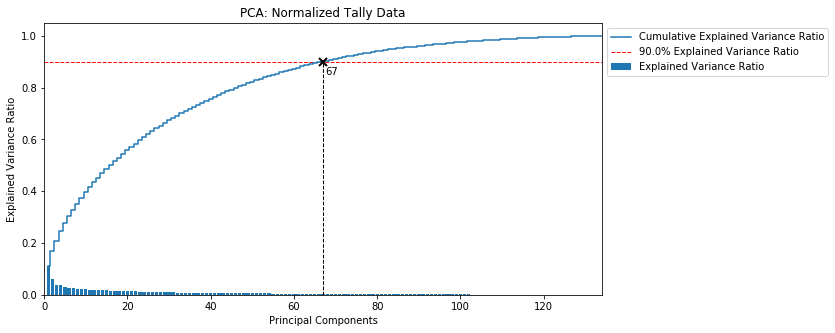

In [25]:
fig = plot_pca_var(tab['tally_norm'].values, 0.90)
plt.title('PCA: Normalized Tally Data')
plt.show()

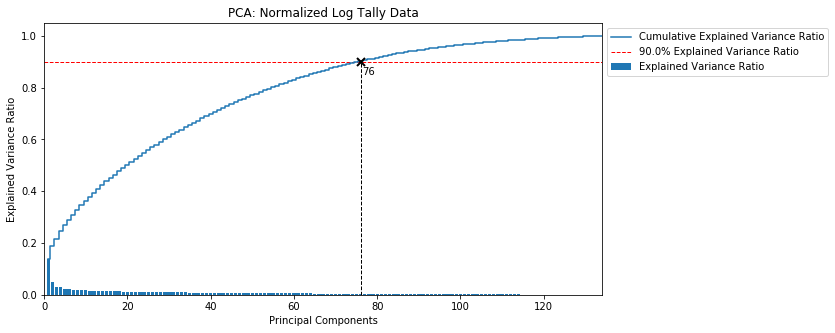

In [26]:
fig = plot_pca_var(tab['tally_log_norm'].values, 0.90)
plt.title('PCA: Normalized Log Tally Data')
plt.show()

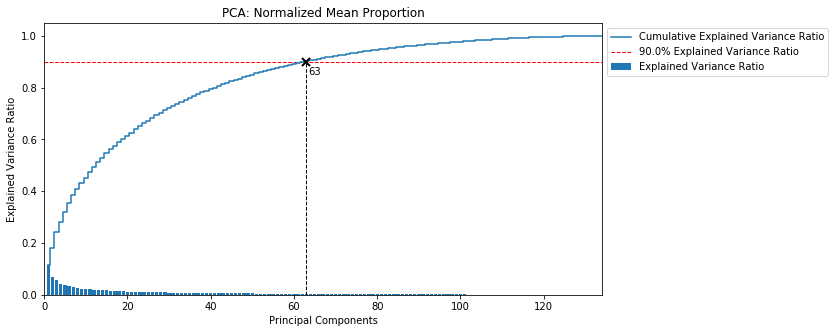

In [27]:
fig = plot_pca_var(tab['p_mean_norm'].values, 0.90)
plt.title('PCA: Normalized Mean Proportion')
plt.show()

In [28]:
n_pca = {'count_norm': 62,
         'count_log_norm': 75,
         'tally_norm': 67,
         'tally_log_norm': 76,
         'p_mean_norm': 63}

### Clustering

##### KMeans

In [35]:
MiniBatchKMeans?

In [36]:
def kmeans_eval(data, n=5, sil_sample_size=10000, verbose=0, n_init=10, batch=False, batch_size=100):
    # Create new df to store results
    df = pd.DataFrame(columns=['model', 'inertia','silhouette', 'calinski'])
    df.index.name = 'k'
    # Copy data to avoid changing original
    X = data.copy()
    
    # Number of samplings to run silhouette scoring
    n_samples=5
    # Fix silhouette sample size if larger than size of data
    if sil_sample_size > data.shape[0]:
        sil_sample_size = None
        n_samples = 1
    
    # Loop through each value of k, fit KMeans, and evaluate
    for k in range(2,n+1):
        if verbose > 0:
            print('Processing k = {} ({}/{})'.format(k, k-1,n-1), end='\r')
        # New temp dictionary for results
        km = {}
        # KMeans model
        if batch:
            km['model'] = MiniBatchKMeans(n_clusters=k, batch_size=batch_size, n_init=n_init)
        else:
            km['model'] = KMeans(n_clusters=k, n_init=n_init)
        km['model'].fit(X)
        # Scoring
        km['inertia'] = km['model'].inertia_
        km['silhouette'] = np.mean([silhouette_score(data, km['model'].labels_, sample_size=sil_sample_size) for i in range(n_samples)])
        km['calinski'] = calinski_harabaz_score(data, km['model'].labels_)
        
        # Add new evaluation to dataframe
        df.loc[k] = km
    
    if verbose > 0:
        print('Complete', ' '*50)
    
    return df

In [74]:
kmeans_results = {}
for d in ['count_norm', 'count_log_norm', 'tally_norm', 'tally_log_norm', 'p_mean_norm']:
    print(d, ':')
    pca = PCA(n_components=n_pca[d])
    X_pca = pca.fit_transform(tab[d].values)
    kmeans_results[d] = kmeans_eval(data=X_pca, n=20, batch=True, batch_size=1000, verbose=1)

count_norm :
Complete                                                   
count_log_norm :
Complete                                                   
tally_norm :
Complete                                                   
tally_log_norm :
Complete                                                   
p_mean_norm :
Complete                                                   


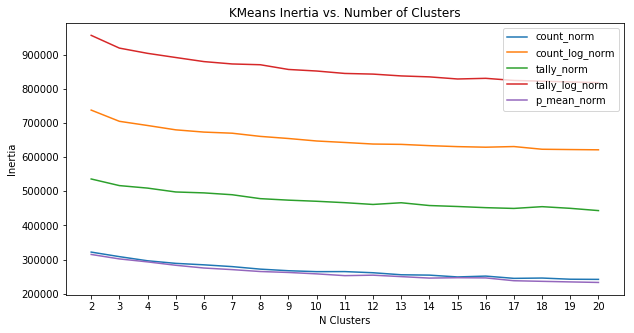

In [78]:
plt.figure(figsize=(10,5))
ax = plt.gca()

for km in kmeans_results:
    ax.plot(kmeans_results[km].index, kmeans_results[km]['inertia'], label=km)

plt.title('KMeans Inertia vs. Number of Clusters')
plt.xlabel('N Clusters')
plt.ylabel('Inertia')
plt.xticks(kmeans_results[km].index,kmeans_results[km].index)
plt.legend()

plt.show()

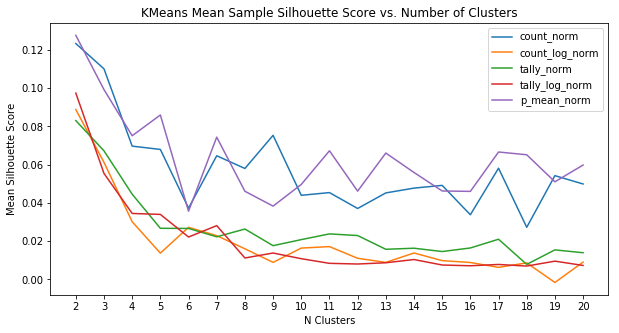

In [79]:
plt.figure(figsize=(10,5))
ax = plt.gca()

for km in kmeans_results:
    ax.plot(kmeans_results[km].index, kmeans_results[km]['silhouette'], label=km)

plt.title('KMeans Mean Sample Silhouette Score vs. Number of Clusters')
plt.xlabel('N Clusters')
plt.ylabel('Mean Silhouette Score')
plt.xticks(kmeans_results[km].index,kmeans_results[km].index)
plt.legend()

plt.show()

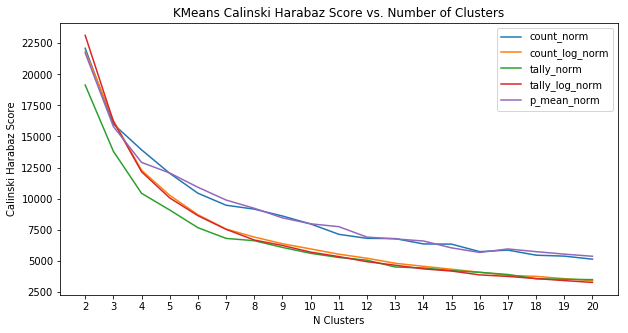

In [77]:
plt.figure(figsize=(10,5))
ax = plt.gca()

for km in kmeans_results:
    ax.plot(kmeans_results[km].index, kmeans_results[km]['calinski'], label=km)

plt.title('KMeans Calinski Harabaz Score vs. Number of Clusters')
plt.xlabel('N Clusters')
plt.ylabel('Calinski Harabaz Score')
plt.xticks(kmeans_results[km].index,kmeans_results[km].index)
plt.legend()

plt.show()

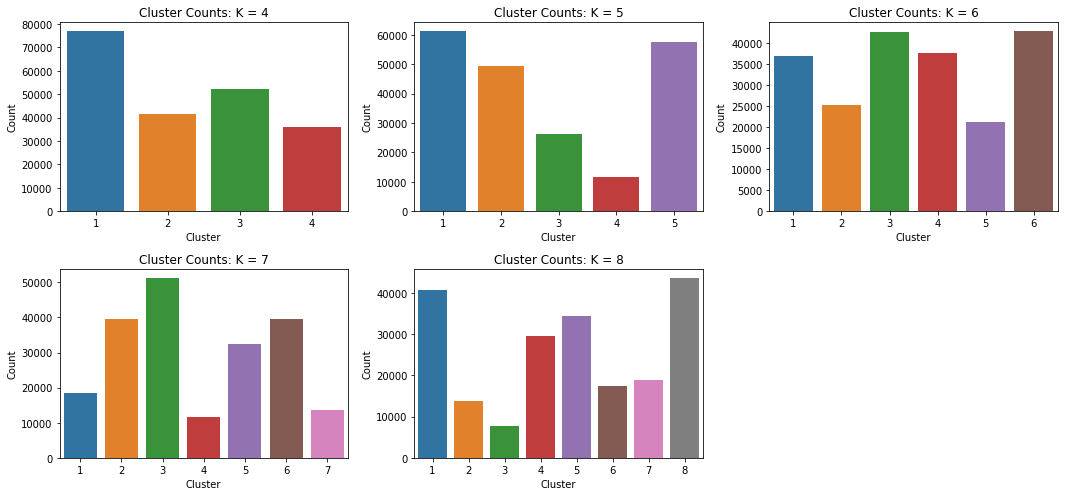

In [83]:
fig, axs = plt.subplots(2,3,figsize=(15,7))

for K, ax in zip(range(4,9),axs.flatten()):
    sns.countplot(kmeans_results['count_norm'].loc[K]['model'].labels_, ax=ax)
    ax.set_title('Cluster Counts: K = {}'.format(K))
    ax.set_xlabel('Cluster')
    ax.set_ylabel('Count')
    ax.set_xticklabels(range(1,K+1))

axs[1][2].axis('off')    
plt.tight_layout()
plt.show()

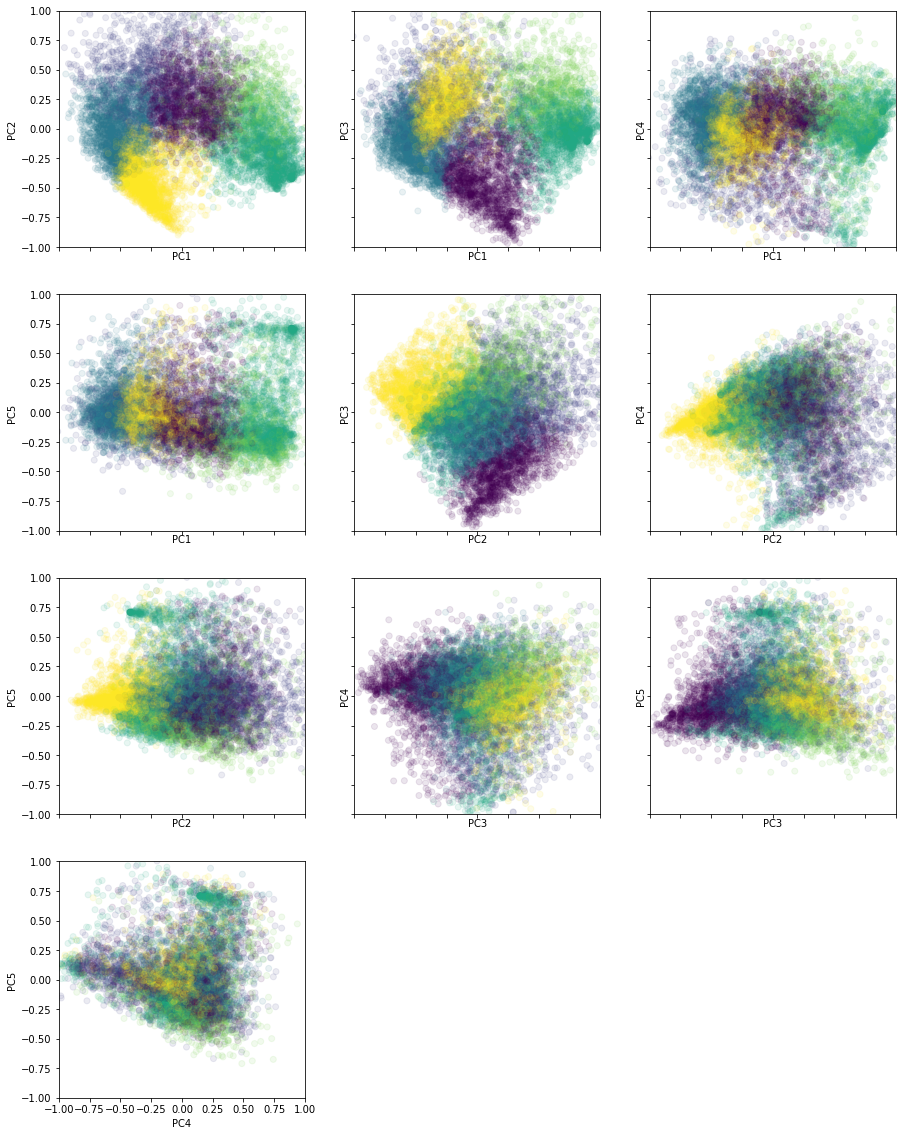

In [84]:
K=6
n_components = 5
combo_list = list(itertools.combinations(np.arange(n_components),2))
n_cols = 3
n_rows = len(combo_list)//n_cols + int(len(combo_list)%n_cols > 0)

fig, axs = plt.subplots(n_rows,n_cols,figsize=(5*n_cols,5*n_rows),sharex=True,sharey=True)

X = PCA(n_components=75).fit_transform(tab['count_norm'])
sample_idx = np.random.choice(X.shape[0], 10000, replace=False)
X_sample = X[sample_idx, :]

for ax, (pc1, pc2) in zip(axs.flatten(), combo_list):
    ax.scatter(x=X_sample.T[pc1], y=X_sample.T[pc2], c=kmeans_results['count_norm'].loc[K]['model'].labels_[sample_idx], alpha=0.1)
    ax.set_xlabel('PC{}'.format(pc1+1))
    ax.set_ylabel('PC{}'.format(pc2+1))
    ax.set_xlim(-1,1)
    ax.set_ylim(-1,1)
    
for ax in axs.flatten()[-(n_cols - len(combo_list)%n_cols):]:
    ax.axis('off')

In [86]:
top_30_aisles = tab['p_mean_norm'].mean().sort_values(ascending=False)[:30].keys()
top_30_aisles

Index(['fresh fruits', 'fresh vegetables', 'packaged vegetables fruits',
       'yogurt', 'water seltzer sparkling water', 'packaged cheese', 'milk',
       'chips pretzels', 'soy lactosefree', 'bread', 'ice cream ice',
       'refrigerated', 'frozen produce', 'soft drinks', 'eggs', 'crackers',
       'frozen meals', 'cereal', 'lunch meat', 'juice nectars',
       'energy granola bars', 'soup broth bouillon', 'baking ingredients',
       'fresh dips tapenades', 'packaged produce', 'hot dogs bacon sausage',
       'paper goods', 'cream', 'other creams cheeses', 'candy chocolate'],
      dtype='object', name='aisle')

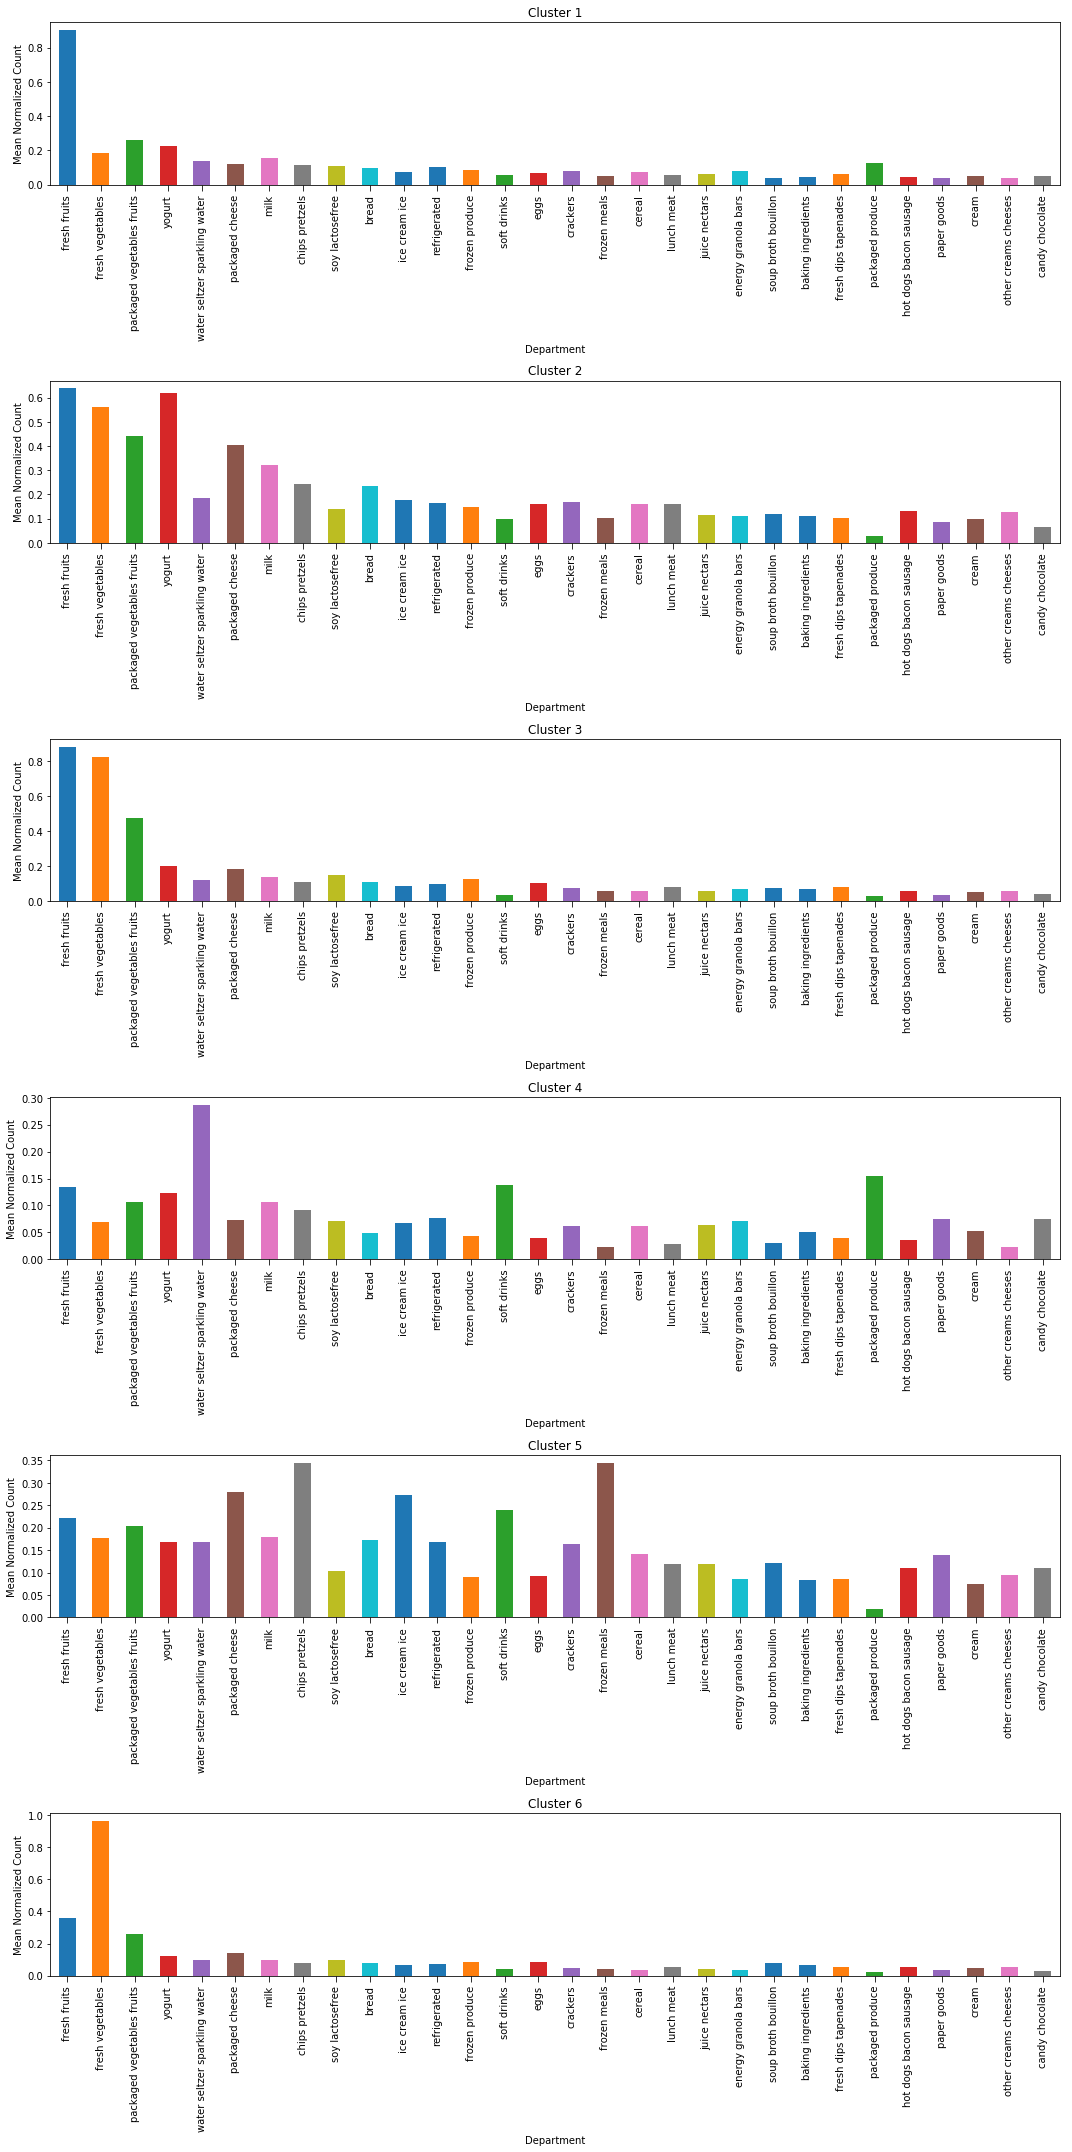

In [88]:
K = 6
clusters = kmeans_results['count_norm']['model'][K].labels_

fig, axs = plt.subplots(K,1,figsize=(15,30))
for i, ax in enumerate(axs.flatten()):
    tab['count_norm'].groupby(clusters).mean().loc[i, top_30_aisles].plot.bar(ax=ax)
    ax.set_title('Cluster {}'.format(i+1))
    ax.set_xlabel('Department')
    ax.set_ylabel('Mean Normalized Count')
    ax.xaxis.set_tick_params(size=6)

plt.tight_layout()
plt.show()

In [86]:
cluster0_orders = train[train['user_id'].isin(tab['count_norm'][clusters==0].index)]
(cluster0_orders['product_name'].value_counts()/cluster0_orders['order_id'].nunique()).sort_values(ascending=False)[:30]

Banana                           0.149025
Bag of Organic Bananas           0.125593
Organic Baby Spinach             0.118750
Organic Strawberries             0.093569
Organic Hass Avocado             0.093306
Organic Avocado                  0.079881
Large Lemon                      0.075855
Limes                            0.074875
Organic Garlic                   0.073935
Organic Yellow Onion             0.073487
Organic Zucchini                 0.069699
Cucumber Kirby                   0.054901
Organic Whole Milk               0.051635
Organic Raspberries              0.049492
Carrots                          0.049148
Fresh Cauliflower                0.048014
Organic Cucumber                 0.046383
Organic Red Onion                0.046367
Organic Cilantro                 0.045884
Michigan Organic Kale            0.045168
Yellow Onions                    0.044991
Organic Small Bunch Celery       0.044432
Organic Lemon                    0.044032
Organic Grape Tomatoes           0

In [89]:
cluster1_orders = train[train['user_id'].isin(tab['count_norm'][clusters==1].index)]
(cluster1_orders['product_name'].value_counts()/cluster1_orders['order_id'].nunique()).sort_values(ascending=False)[:30]

Banana                                  0.220304
Bag of Organic Bananas                  0.197890
Organic Strawberries                    0.137597
Organic Hass Avocado                    0.095722
Organic Baby Spinach                    0.086134
Strawberries                            0.080400
Organic Avocado                         0.075926
Organic Raspberries                     0.058474
Large Lemon                             0.054113
Organic Whole Milk                      0.051519
Organic Blueberries                     0.047223
Organic Fuji Apple                      0.044817
Limes                                   0.044688
Apple Honeycrisp Organic                0.042598
Honeycrisp Apple                        0.040721
Seedless Red Grapes                     0.039036
Organic Large Extra Fancy Fuji Apple    0.038272
Organic Gala Apples                     0.037296
Raspberries                             0.034305
Organic Baby Carrots                    0.033946
Organic Blackberries

In [91]:
cluster2_orders = train[train['user_id'].isin(tab['count_norm'][clusters==2].index)]
(cluster2_orders['product_name'].value_counts()/cluster2_orders['order_id'].nunique()).sort_values(ascending=False)[:30]

Banana                             0.038236
Soda                               0.037624
Bag of Organic Bananas             0.032467
Sparkling Water Grapefruit         0.025528
Spring Water                       0.023649
Hass Avocados                      0.022368
Organic Half & Half                0.021755
Raspberries                        0.018098
Clementines                        0.017837
Organic Baby Spinach               0.017191
Lime Sparkling Water               0.017159
Strawberries                       0.017070
Sparkling Natural Mineral Water    0.015475
Half & Half                        0.015198
Sparkling Lemon Water              0.014327
2% Reduced Fat Milk                0.013985
Sparkling Mineral Water            0.013583
Organic Whole Milk                 0.013495
Organic Strawberries               0.012994
Fridge Pack Cola                   0.012962
Baby Cucumbers                     0.011888
Organic Blueberries                0.011503
Pure Sparkling Water            

### DBSCAN

In [ ]:
sample = tab['p_mean_norm'].sample(n=20000)
X_sample = sample.values
X_pca = PCA(n_components=n_pca['p_mean_norm']).fit_transform(X_sample)

In [ ]:
pairDistList = pdist(X_pca, metric='mahalanobis')

In [ ]:
figPairwiseDistances = plt.figure(figsize=(10,8))
plt.hist(pairDistList, bins=200, color='seagreen')
plt.show()

In [99]:
def neighborhoods(data, epsilon):
    n_data = data.shape[0]
    nn = np.zeros(n_data)
    # Compute all - n(n-1)/2 - pairwise distances
    pMat = pdist(data)
    # Compute the (i,j) indexes of pairs that correspond to each elements in pMat
    indexes = np.array([ (i,j) for i in range(n_data) for j in range(i+1, n_data)])
    # Find pairs of data points that are closer than epsilon
    pairs = indexes[np.where(pMat < epsilon)]
    for pair in pairs:
        nn[pair[0]] += 1
        nn[pair[1]] += 1
    return nn

In [100]:
nn = neighborhoods(X_pca, 1.0)

KeyboardInterrupt: 

In [ ]:
figNeighborhoods = plt.figure(figsize=(10,8))
plt.hist(nn, bins=np.arange(min(nn), max(nn) + 1, 1), color='darkorange')
plt.xlim(0,100)
plt.show()

In [101]:
def kDist_multi(data, k_range):
    nData = data.shape[0]
    pDistMat = squareform(pdist(data))
    kDistResults = {}
    kDistSorted = [ sorted(pDistMat[i,:]) for i in range(nData) ]
    for k in k_range:
        kDistArray = [ kDistSorted[i][k-1] for i in range(nData)]
        kDistResults[k] = sorted(kDistArray, reverse=True)
    return kDistResults

In [108]:
kDistResults = kDist_multi(X_pca, [4,5,6,10,20])

(1.8, 3.2761217755413377)

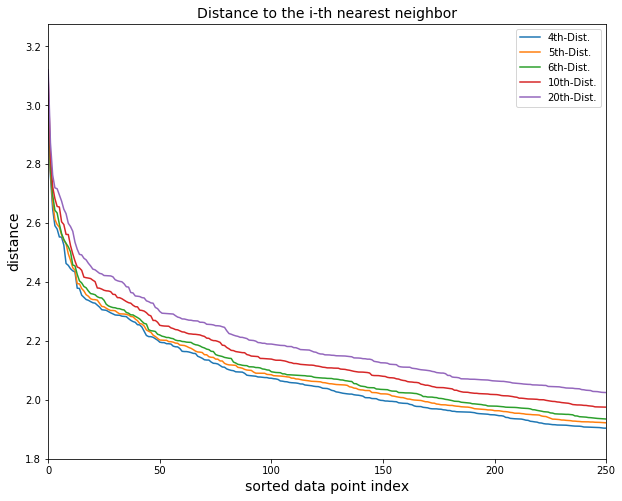

In [111]:
figKDist = plt.figure(figsize=(10,8))

n_data = X_pca.shape[0]

for k in [4,5,6,10,20]:
    plt.plot(range(n_data), kDistResults[k], label='{}th-Dist.'.format(k))

plt.xlim([0,250])
plt.xlabel('sorted data point index', size=14)
plt.ylabel('distance', size=14)
plt.title('Distance to the i-th nearest neighbor', size=14)
plt.legend()
plt.ylim(bottom=1.8)

In [159]:
np.log(tab['count_norm'].shape[0])

12.23664549655721

In [158]:
np.log(X_pca.shape[0])

9.903487552536127

In [160]:
db = DBSCAN(eps=2.4, min_samples=10)
db.fit(X_pca)

DBSCAN(algorithm='auto', eps=2.4, leaf_size=30, metric='euclidean',
    metric_params=None, min_samples=10, n_jobs=1, p=None)

In [161]:
set(db.labels_)

{-1, 0}

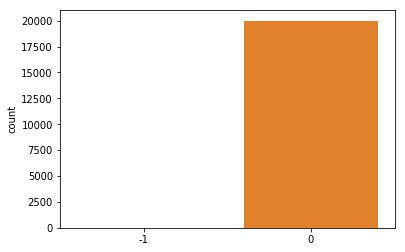

In [162]:
sns.countplot(db.labels_)

In [42]:
20 / 4

5.0

In [64]:
c1 = np.array([4, 7, 2, 7])
c2 = np.array([5, 5, 5, 5])
c3 = np.array([5, 5, 6, 4])
c4 = np.array([16, 2, 1, 1])

In [52]:
((c1 - 5)**2).sum()/4

4.5

In [53]:
((c2 - 5)**2).sum()/4

0.0

In [54]:
((c3 - 5)**2).sum()/4

0.5

In [55]:
((c4 - 5)**2).sum()/4

40.5

In [56]:
c4.min()

1

In [63]:
(np.sqrt((0.03**2+0.02 **2+0.61**2+0.02 **2+0.03 **2+0.07**2+0.06 **2+0.05**2+0.06**2+0.05)) * np.sqrt(10) - 1)/(np.sqrt(10)-1)

0.5068490938225457

In [107]:
def cluster_uniformity(cluster_counts):
    d = len(cluster_counts)
    n = sum(cluster_counts)
    norm = [count / n for count in cluster_counts]
    l2 = np.sqrt(sum([x**2 for x in norm]))
    u = 1 - (l2*np.sqrt(d)-1)/(np.sqrt(d)-1)
    return u

In [132]:
def dbscan_gs(data, eps=[0.5,1.0], min_samples=[4,5,6], verbose=0):
    f_start_time = time.time()
    n_tests = len(eps)*len(min_samples)
    if verbose > 0:
        print('--- DBSCAN grid search ---')
        print('Total samples = {}'.format(data.shape[0]))
        print('eps values: {}'.format([round(e, 2) for e in eps]))
        print('min_samples values: {}'.format([ms for ms in min_samples]))
        print('Tests = {}'.format(n_tests))
        print('--------------------------')
    # create a dataframe for holding our results
    dbscan_results = pd.DataFrame(columns=['eps', 'min_samples', 'n_clusters', 'cluster_uniformity','cluster_counts','noise_pts'])
    dbscan_results = dbscan_results[['eps', 'min_samples', 'n_clusters', 'cluster_uniformity','cluster_counts','noise_pts']]

    # create values for testing eps & min samples
    params = {'eps': eps,
              'min_samples': min_samples}

    for i, (e, ms) in enumerate(itertools.product(params['eps'],params['min_samples'])):
        start_time = time.time()
        if verbose > 0:
            print('eps: {:.3f}, min_samples: {:.0f}... Fitting DBSCAN {}/{}'.format(e,ms,i+1,n_tests), end='\r')
        db = DBSCAN(eps=e, min_samples=ms).fit(data)
        labels = db.labels_
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        cluster_counts = np.bincount(labels[labels != -1]).tolist()
        noise_pts = np.sum(labels < 0)
        cluster_uni = cluster_uniformity(cluster_counts) if n_clusters > 1 else np.nan
        if verbose > 0:
            time_delta = time.time() - start_time
            m = time_delta//60
            s = time_delta%60
            time_display = ('{}min '.format(m) if m > 0 else '') + '{:.2f}s'.format(s)
            print('eps: {:.3f}, min_samples: {:.0f}, clusters: {}, uniformity: {:.2f}, noise: {:d}   ({})'.format(e, ms, n_clusters, cluster_uni,noise_pts, time_display)) 

        df_pt = pd.DataFrame({'eps':[e],
                             'min_samples':[ms],
                             'n_clusters':[n_clusters],
                             'cluster_uniformity': cluster_uni,
                             'cluster_counts': [cluster_counts],
                             'noise_pts': [noise_pts]})

        dbscan_results = pd.concat([dbscan_results, df_pt],axis=0)
    
    if verbose > 0:
        time_delta = time.time() - f_start_time
        m = time_delta//60
        s = time_delta%60
        time_display = ('{}min '.format(m) if m > 0 else '') + '{:.2f}s'.format(s)
        print('--------------------------')
        print('Total run time: {}'.format(time_display))
    
    return dbscan_results

In [126]:
dbscan_results = dbscan_gs(X_pca, eps=np.arange(0.5,2.6,0.5), min_samples=[4,5,6,10,12,15,20], verbose=1)

--- DBSCAN grid search ---
Total samples = 20000
eps values: ['0.500', '1.000', '1.500', '2.000', '2.500']
min_samples values: [4, 5, 6, 10, 12, 15, 20]
Tests = 35
--------------------------
eps: 0.500, min_samples: 4, clusters: 27, uniformity: 0.14, noise: 15567   (46.87s)
eps: 0.500, min_samples: 5, clusters: 26, uniformity: 0.14, noise: 15634   (50.89s)
eps: 0.500, min_samples: 6, clusters: 19, uniformity: 0.14, noise: 15708   (45.80s)
eps: 0.500, min_samples: 10, clusters: 15, uniformity: 0.22, noise: 15857   (45.59s)
eps: 0.500, min_samples: 12, clusters: 16, uniformity: 0.26, noise: 15915   (47.86s)
eps: 0.500, min_samples: 15, clusters: 12, uniformity: 0.25, noise: 16028   (49.78s)
eps: 0.500, min_samples: 20, clusters: 10, uniformity: 0.24, noise: 16157   (51.25s)
eps: 1.000, min_samples: 4, clusters: 2, uniformity: 0.00, noise: 5670   (2.0min 3.51s)


C:\Users\David\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


eps: 1.000, min_samples: 5, clusters: 1, uniformity: nan, noise: 5712   (2.0min 6.46s)


C:\Users\David\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


eps: 1.000, min_samples: 6, clusters: 1, uniformity: nan, noise: 5738   (2.0min 7.63s)


C:\Users\David\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


eps: 1.000, min_samples: 10, clusters: 1, uniformity: nan, noise: 5808   (1.0min 54.58s)


C:\Users\David\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


eps: 1.000, min_samples: 12, clusters: 1, uniformity: nan, noise: 5829   (2.0min 8.16s)


C:\Users\David\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


eps: 1.000, min_samples: 15, clusters: 1, uniformity: nan, noise: 5876   (2.0min 9.25s)


C:\Users\David\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


eps: 1.000, min_samples: 20, clusters: 1, uniformity: nan, noise: 5927   (2.0min 9.86s)


C:\Users\David\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


eps: 1.500, min_samples: 4, clusters: 1, uniformity: nan, noise: 946   (2.0min 9.10s)


C:\Users\David\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


eps: 1.500, min_samples: 5, clusters: 1, uniformity: nan, noise: 948   (2.0min 17.81s)


C:\Users\David\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


eps: 1.500, min_samples: 6, clusters: 1, uniformity: nan, noise: 949   (2.0min 21.32s)


C:\Users\David\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


eps: 1.500, min_samples: 10, clusters: 1, uniformity: nan, noise: 956   (2.0min 26.23s)


C:\Users\David\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


eps: 1.500, min_samples: 12, clusters: 1, uniformity: nan, noise: 957   (2.0min 15.87s)


C:\Users\David\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


eps: 1.500, min_samples: 15, clusters: 1, uniformity: nan, noise: 958   (2.0min 21.50s)


C:\Users\David\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


eps: 1.500, min_samples: 20, clusters: 1, uniformity: nan, noise: 961   (2.0min 28.63s)


C:\Users\David\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


eps: 2.000, min_samples: 4, clusters: 1, uniformity: nan, noise: 40   (2.0min 38.52s)


C:\Users\David\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


eps: 2.000, min_samples: 5, clusters: 1, uniformity: nan, noise: 40   (2.0min 17.70s)


C:\Users\David\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


eps: 2.000, min_samples: 6, clusters: 1, uniformity: nan, noise: 40   (2.0min 13.84s)


C:\Users\David\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


eps: 2.000, min_samples: 10, clusters: 1, uniformity: nan, noise: 40   (2.0min 28.19s)


C:\Users\David\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


eps: 2.000, min_samples: 12, clusters: 1, uniformity: nan, noise: 40   (2.0min 18.09s)


C:\Users\David\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


eps: 2.000, min_samples: 15, clusters: 1, uniformity: nan, noise: 40   (2.0min 27.24s)


C:\Users\David\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


eps: 2.000, min_samples: 20, clusters: 1, uniformity: nan, noise: 40   (2.0min 31.73s)


C:\Users\David\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


eps: 2.500, min_samples: 4, clusters: 1, uniformity: nan, noise: 2   (2.0min 22.31s)


C:\Users\David\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


eps: 2.500, min_samples: 5, clusters: 1, uniformity: nan, noise: 2   (2.0min 6.22s)


C:\Users\David\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


eps: 2.500, min_samples: 6, clusters: 1, uniformity: nan, noise: 2   (2.0min 8.16s)


C:\Users\David\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


eps: 2.500, min_samples: 10, clusters: 1, uniformity: nan, noise: 2   (2.0min 13.80s)


C:\Users\David\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


eps: 2.500, min_samples: 12, clusters: 1, uniformity: nan, noise: 2   (2.0min 23.94s)


C:\Users\David\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


eps: 2.500, min_samples: 15, clusters: 1, uniformity: nan, noise: 2   (2.0min 14.20s)
eps: 2.500, min_samples: 20, clusters: 1, uniformity: nan, noise: 2   (2.0min 26.08s)
--------------------------
Total run time: 69.0min 28.07s


C:\Users\David\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


In [127]:
dbscan_results

,cluster_counts,cluster_uniformity,eps,min_samples,n_clusters,noise_pts
0,"[3940, 118, 83, 12, 9, 42, 37, 30, 5, 18, 5, 3...",0.136744,0.5,4,27,15567
0,"[3871, 117, 82, 12, 36, 37, 28, 5, 18, 5, 22, ...",0.140051,0.5,5,26,15634
0,"[3821, 110, 82, 12, 25, 36, 36, 28, 18, 21, 32...",0.141403,0.5,6,19,15708
0,"[3468, 87, 79, 35, 269, 35, 27, 12, 16, 16, 21...",0.215320,0.5,10,15,15857
0,"[3280, 83, 142, 77, 35, 268, 34, 16, 20, 12, 2...",0.257264,0.5,12,16,15915
0,"[3244, 80, 136, 76, 35, 266, 34, 16, 21, 26, 2...",0.251900,0.5,15,12,16028
0,"[3210, 119, 30, 208, 78, 53, 74, 22, 28, 21]",0.236489,0.5,20,10,16157
0,"[14325, 5]",0.001191,1.0,4,2,5670
0,[14288],NaN,1.0,5,1,5712
0,[14262],NaN,1.0,6,1,5738


In [131]:
np.arange(0.5,1.0,0.1)

array([0.5, 0.6, 0.7, 0.8, 0.9])

In [133]:
dbscan_results_2 = dbscan_gs(X_pca, eps=np.arange(0.5,1.1,0.1), min_samples=np.arange(10,101,10), verbose=1)

--- DBSCAN grid search ---
Total samples = 20000
eps values: [0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1]
min_samples values: [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
Tests = 70
--------------------------
eps: 0.500, min_samples: 10, clusters: 15, uniformity: 0.22, noise: 15857   (44.75s)
eps: 0.500, min_samples: 20, clusters: 10, uniformity: 0.24, noise: 16157   (44.15s)
eps: 0.500, min_samples: 30, clusters: 6, uniformity: 0.21, noise: 16384   (44.45s)
eps: 0.500, min_samples: 40, clusters: 5, uniformity: 0.20, noise: 16490   (44.46s)
eps: 0.500, min_samples: 50, clusters: 3, uniformity: 0.18, noise: 16659   (44.24s)
eps: 0.500, min_samples: 60, clusters: 2, uniformity: 0.20, noise: 16769   (44.34s)
eps: 0.500, min_samples: 70, clusters: 3, uniformity: 0.29, noise: 16825   (44.34s)
eps: 0.500, min_samples: 80, clusters: 3, uniformity: 0.28, noise: 16863   (43.92s)
eps: 0.500, min_samples: 90, clusters: 3, uniformity: 0.28, noise: 16903   (44.41s)
eps: 0.500, min_samples: 100, clusters: 3, un

In [ ]:
dbscan_results_3 = dbscan_gs(X_pca, eps=np.arange(0.5,1.1,0.1), min_samples=np.arange(10,101,10), verbose=1)

In [134]:
dbscan_results_2

,cluster_counts,cluster_uniformity,eps,min_samples,n_clusters,noise_pts
0,"[3468, 87, 79, 35, 269, 35, 27, 12, 16, 16, 21...",0.215320,0.5,10,15,15857
0,"[3210, 119, 30, 208, 78, 53, 74, 22, 28, 21]",0.236489,0.5,20,10,16157
0,"[3149, 197, 54, 108, 64, 44]",0.213845,0.5,30,6,16384
0,"[3117, 197, 98, 45, 53]",0.198152,0.5,40,5,16490
0,"[3073, 196, 72]",0.184774,0.5,50,3,16659
0,"[3038, 193]",0.197472,0.5,60,2,16769
0,"[2775, 185, 215]",0.287308,0.5,70,3,16825
0,"[2747, 185, 205]",0.283709,0.5,80,3,16863
0,"[2714, 185, 198]",0.282293,0.5,90,3,16903
0,"[2665, 181, 192]",0.280348,0.5,100,3,16962
